<a href="https://colab.research.google.com/github/animesh-77/Active-Fire-Detection/blob/3algo/Generate_masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.getcwd()

'/content'

In [55]:
!git clone --branch 3algo https://github.com/animesh-77/Active-Fire-Detection.git

Cloning into 'Active-Fire-Detection'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 173 (delta 37), reused 94 (delta 35), pack-reused 73
Receiving objects: 100% (173/173), 42.05 MiB | 20.40 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [3]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.9 MB 1.2 MB/s 


In [5]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Common functions used

In [20]:
def normalise_RGB(img):
    img2= np.zeros(img.shape, dtype= float)
    for channel in range(3):
        img_band= img[:,:,channel]
        max_dn, min_dn= np.max(img_band), np.min(img_band)
        img_band = np.subtract(img_band, min_dn, casting= "unsafe")
        img_band = np.divide(img_band, (max_dn- min_dn), casting= "unsafe")
        img2[:,:,channel]= img_band
    return img2

In [21]:
# not using it right now

def get_saturation(BQA):
    """
    BQA a 2d numpy array with 16bit values
    
    returns
    a 2d array with all pixels with value 1 have at least 1 saturated bands
    """
    vals = [2724,2756,2804,2980,3012,3748,3780,6820,6852,6900,7076,7108,7844,7876,
            2728,2760,2808,2984,3016,3752,3784,6824,6856,6904,7080,7112,7848,7880,
            2732,2764,2812,2988,3020,3756,3788,6828,6860,6908,7084,7116,7852,7884]
    
    sat = np.zeros((BQA.shape), dtype=bool)

    for val in vals:
        sat = sat | (BQA==val)
        
    return sat.astype(int)

In [22]:
def getReflectance (band, add_band, mult_band, sun_elevation):
    '''A tiny function, used just to compute the Top of the Atmosphere reflectances, with correction
    for solar angle (given in degrees).
    band : all bands OR bands 1-7
    '''
    p = ((band * mult_band) + add_band) # TOA planetary reflectance, without correction for solar angle
    corrected = p / np.sin(np.radians (sun_elevation)) # TOA planetary reflectance, with correction for solar angle

    return p, corrected

# Murphy masks

We note that without the BQA file we cannot estimate the saturation of the band 6 or 5. Thus the $\beta$ value are affected. 

In [31]:
#===============================================================================
# EQUATIONS (MURPHY)
#===============================================================================
# The following functions implement the equations in the Murphy's paper.

import cv2

def Meq2 (bands):
    '''Eq 2 (unambiguous fires).'''

    # Avoid divisions by 0!
    p5 = np.where (bands[5] == 0, np.finfo (float).eps, bands[5])
    p6 = np.where (bands[6] == 0, np.finfo (float).eps, bands[6])
    return (np.logical_and (bands[7] >= 0.15, np.logical_and (bands[7]/p6 >= 1.4, bands[7]/p5 >= 1.4)))

#-------------------------------------------------------------------------------

def Meq3 (bands, unamb, sat):
    '''Eq 3 (potential fires).'''

    neighborhood = cv2.dilate (unamb.astype (int), cv2.getStructuringElement (cv2.MORPH_RECT, (3,3))).astype (unamb.dtype)
    # Striclty speaking, we should take out from the neighborhood the pixels
    # that were set by eq 2, but the results will be joined anyway...
    #neighborhood = np.logical_xor (neighborhood, unamb)

    # Avoid divisions by 0!
    p5 = np.where (bands[5] > 0, np.finfo (float).eps, bands[5])
    return (np.logical_and (neighborhood, np.logical_or (np.logical_and (bands[6]/p5 >= 2.0, bands[6]>=0.5), sat)))


In [32]:
def getFireMaskMurphy (bands, saturated):
    '''This is the central function. Receives the (corrected) reflectance bands
and a binary mask indicating saturated pixels, and returns a binary fire mask.
    bands : all 10 bands. OR bands 1-7
    '''

    unamb_fires = Meq2 (bands)
    if np.any (unamb_fires): # Run eq 3 only if needed.
        # potential_fires = Meq3 (bands, unamb_fires, saturated)
        potential_fires = False
        final_mask = (unamb_fires | potential_fires)
        pass
    else:
        final_mask = unamb_fires

    return (final_mask.astype (int))

In [33]:
lines_to_see= [f"REFLECTANCE_MULT_BAND_{i}" for i in [5,6,7]]
lines_to_see.extend([f"REFLECTANCE_ADD_BAND_{i}" for i in [5,6,7]])
lines_to_see.append("SUN_ELEVATION")

with open("/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Metadata/LC08_L1TP_067091_20200810_20200810_01_RT_MTL.txt") as f:
    for line in f.readlines():
        if any(item in line for item in lines_to_see):
            print(line)

    SUN_ELEVATION = 21.64943273

    REFLECTANCE_MULT_BAND_5 = 2.0000E-05

    REFLECTANCE_MULT_BAND_6 = 2.0000E-05

    REFLECTANCE_MULT_BAND_7 = 2.0000E-05

    REFLECTANCE_ADD_BAND_5 = -0.100000

    REFLECTANCE_ADD_BAND_6 = -0.100000

    REFLECTANCE_ADD_BAND_7 = -0.100000



In [34]:
m5, m6, m7= 2.0000E-05, 2.0000E-05, 2.0000E-05
a5, a6, a7= -0.100000, -0.100000, -0.100000
sun_el = 21.64943273  

In [35]:
scenes_path= [os.path.join("/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Scenes", i) for i in 
              os.listdir("/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Scenes") 
              if i.endswith(".tif")]
scenes_path.sort()

masks_path = [os.path.join("/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Masks", i) for i in 
              os.listdir("/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Masks") 
              if (i.endswith(".tif") and "Murphy" in i)]
masks_path.sort()

In [36]:
display(scenes_path)
display(masks_path)

['/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Scenes/LC08_L1TP_067091_20200810_20200810_01_RT_p00582.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Scenes/LC08_L1TP_067091_20200810_20200810_01_RT_p00583.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Scenes/LC08_L1TP_067091_20200810_20200810_01_RT_p00690.tif']

['/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Masks/LC08_L1TP_067091_20200810_20200810_01_RT_Murphy_p00582.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Masks/LC08_L1TP_067091_20200810_20200810_01_RT_Murphy_p00583.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z067091/Masks/LC08_L1TP_067091_20200810_20200810_01_RT_Murphy_p00690.tif']

Are masks same ? True


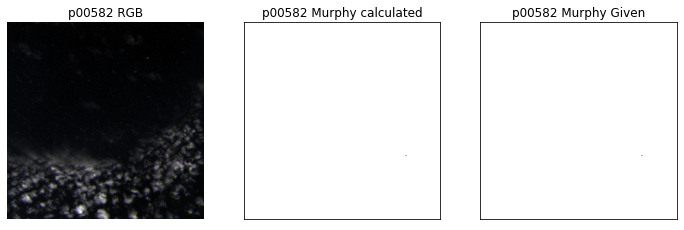

Are masks same ? True


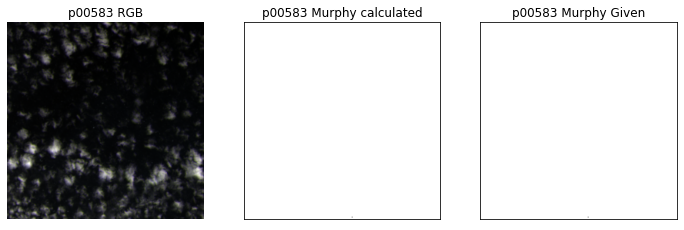

Are masks same ? False


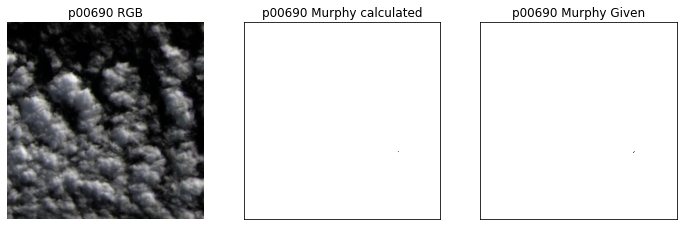

In [38]:
for index,paths in enumerate(zip(scenes_path, masks_path)):
    scene_path, mask_path= paths[0], paths[1]
    img= rasterio.open(scene_path)
    bands= img.read()
    img.close()

    b2= np.zeros((bands.shape[0]+1, bands.shape[1], bands.shape[2]), dtype= np.uint16)
    b2[1:]= bands
    bands= b2

    reflectance = np.zeros(bands.shape, dtype= float)
    corrected = np.zeros(bands.shape, dtype= float)
    
    # Get corrected reflectances for bands 1~7.
    for i in range (1,8):
        reflectance [i], corrected [i] = getReflectance(bands [i], a5, m5, sun_el)

    rgb= np.dstack((corrected[4], corrected[3], corrected[2]))
    rgb= normalise_RGB(rgb)

    sat= np.zeros(reflectance.shape, dtype= int)
    murphy_mask= getFireMaskMurphy(corrected, sat)

    img= rasterio.open(mask_path)
    actual_mask= img.read()
    actual_mask= np.squeeze(actual_mask)
    img.close()

    print("Are masks same ?", np.all(actual_mask== murphy_mask))
    fig, ax = plt.subplots(1, 3, figsize=(12,40))
    scene_index= scene_path.split("/")[-1].split("_")[-1:]
    scene_index= "_".join(scene_index)[:-4]
    ax[0].imshow(rgb)
    ax[0].axis("off")
    ax[0].set_title(scene_index+" RGB")

    ax[1].set_title(scene_index+" Murphy calculated")
    ax[1].imshow(murphy_mask, cmap= "binary")
    ax[1].get_xaxis().set_ticks([])
    ax[1].get_yaxis().set_ticks([])

    ax[2].set_title(scene_index+" Murphy Given")
    ax[2].imshow(actual_mask, cmap= "binary")
    ax[2].get_xaxis().set_ticks([])
    ax[2].get_yaxis().set_ticks([])

    plt.show()

    

# Schroeder Masks

In [18]:
#===============================================================================
# EQUATIONS (Schroeder)
#===============================================================================
# The following functions implement the equations in the paper.

def Seq1 (bands, r75, diff75):
    '''Eq 1 (unambiguous fires).
    r75 = rho7/ rho5
    diff75= rho7- rho5
    '''
    return (np.logical_and (bands [7] > 0.5, np.logical_and (r75 > 2.5, diff75 > 0.3)))

#-------------------------------------------------------------------------------

def Seq2 (bands):
    '''Eq 2 (unambiguous fires).'''
    return (np.logical_and (bands [6] > 0.8, np.logical_and (bands [1] < 0.2, np.logical_or (bands [5] > 0.4, bands [7] < 0.1))))

#-------------------------------------------------------------------------------

def Seq3 (r75, diff75):
    '''Eq 3 (potential fires).
    r75 = rho7/ rho5
    diff75= rho7- rho5
    '''
    return (np.logical_and (r75 > 1.8, diff75 > 0.17))

#-------------------------------------------------------------------------------

def Seq4and5 (bands, r75, unamb_fires, potential_fires, water):
    '''Eq 4 and 5 (contextual test for potential fires).'''

    # Means and standard deviations are computed ignoring unambiguous fires, as
    # well as water pixels.
    ignored_pixels = np.logical_or (bands [7] <= 0, np.logical_or (unamb_fires, water))
    kept_pixels = np.logical_not (ignored_pixels)

    # Reason between bands 7 and 5
    r75_ignored = r75.copy ()
    r75_ignored [ignored_pixels] = np.nan # Fire and water pixels are set to NaN.

    band7_ignored = bands [7].copy ()
    band7_ignored [ignored_pixels] = np.nan # Fire and water pixels are set to NaN.

    # Test potential fires.
    candidates = np.nonzero (potential_fires)
    for i in range (len (candidates [0])):
        y = candidates [0][i]
        x = candidates [1][i]

        # 61x61 window.
        t = max (0,y-30)
        b = min (potential_fires.shape [0], y+31)
        l = max (0, x-30)
        r = min (potential_fires.shape [1], x+31)

        eq4_result = r75 [y,x] > np.nanmean (r75_ignored [t:b,l:r]) + np.maximum (3 * (np.nanstd (r75_ignored [t:b,l:r])), 0.8)
        eq5_result = bands [7][y,x] > np.nanmean (band7_ignored [t:b,l:r]) + np.maximum (3 * (np.nanstd (band7_ignored [t:b,l:r])), 0.08)
        if not (eq4_result) or not (eq5_result):
            potential_fires [y,x] = False

    return potential_fires

#-------------------------------------------------------------------------------

def Seq6 (bands):
    '''Eq 6 (additional test for potential fires).'''
    # Avoid divisions by 0!
    p6 = np.where (bands[6] == 0, np.finfo (float).eps, bands[6])
    return (bands [7] / p6 > 1.6)

#-------------------------------------------------------------------------------

def Seq7_8_9 (bands):
    '''Eq 7, 8 and 9 (water test).'''
    result7 = np.logical_and (bands [4] > bands [5], np.logical_and (bands [5] > bands [6], np.logical_and (bands [6] > bands [7], bands [1] - bands [7] < 0.2)))
    return (np.logical_and (result7, np.logical_or (bands [3] > bands [2], np.logical_and (bands [1] > bands [2], np.logical_and (bands [2] > bands [3], bands [3] > bands [4])))))



In [50]:
def getFireMaskSchroeder (bands):

    r75 = bands [7] / bands [5] # Compute only once (used by multiple equations).
    diff75 = bands [7] - bands [5] # Compute only once (used by multiple equations).

    # Unambiguous fires (satisfy eq 1 or 2).
    unamb_fires = Seq1 (bands, r75, diff75)
    unamb_fires = np.logical_or (unamb_fires, Seq2 (bands))

    # Potential fires (satisfy eq 3).
    potential_fires = Seq3 (r75, diff75)

    # Test eq 6 before eq 4 and 5 in an attempt to avoid the time-consuming contextual test when possible.
    potential_fires = np.logical_and (potential_fires, Seq6 (bands))

    # Water pixels (used by the contextual test and excluded from the result.
    water = Seq7_8_9 (bands)

    # Contextual test for potential fires (eq 4 and 5).
    if np.any (potential_fires):
        potential_fires = Seq4and5 (bands, r75, unamb_fires, potential_fires, water)

    final_mask = np.logical_and (np.logical_or (unamb_fires, potential_fires), np.logical_not (water))
    return (final_mask.astype (int))

In [66]:
lines_to_see= [f"REFLECTANCE_MULT_BAND_{i}" for i in [5,6,7]]
lines_to_see.extend([f"REFLECTANCE_ADD_BAND_{i}" for i in [5,6,7]])
lines_to_see.append("SUN_ELEVATION")

with open("/content/Active-Fire-Detection/paper data/Oceania/Images1/z072087/Metadata/LC08_L1TP_072087_20200829_20200830_01_RT_MTL.txt") as f:
    for line in f.readlines():
        if any(item in line for item in lines_to_see):
            print(line)

    SUN_ELEVATION = 32.82452914

    REFLECTANCE_MULT_BAND_5 = 2.0000E-05

    REFLECTANCE_MULT_BAND_6 = 2.0000E-05

    REFLECTANCE_MULT_BAND_7 = 2.0000E-05

    REFLECTANCE_ADD_BAND_5 = -0.100000

    REFLECTANCE_ADD_BAND_6 = -0.100000

    REFLECTANCE_ADD_BAND_7 = -0.100000



In [67]:
m5, m6, m7= 2.0000E-05, 2.0000E-05, 2.0000E-05
a5, a6, a7= -0.100000, -0.100000, -0.100000
sun_el = 32.82452914 

In [68]:
scenes_path= [os.path.join("/content/Active-Fire-Detection/paper data/Oceania/Images1/z072087/Scenes", i) for i in 
              os.listdir("/content/Active-Fire-Detection/paper data/Oceania/Images1/z072087/Scenes") 
              if i.endswith(".tif")]
scenes_path.sort()

masks_path = [os.path.join("/content/Active-Fire-Detection/paper data/Oceania/Images1/z072087/Masks", i) for i in 
              os.listdir("/content/Active-Fire-Detection/paper data/Oceania/Images1/z072087/Masks") 
              if (i.endswith(".tif") and "Schroeder" in i)]
masks_path.sort()

In [69]:
display(scenes_path)
display(masks_path)

['/content/Active-Fire-Detection/paper data/Oceania/Images1/z072087/Scenes/LC08_L1TP_072087_20200829_20200830_01_RT_p00264.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z072087/Scenes/LC08_L1TP_072087_20200829_20200830_01_RT_p00584.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z072087/Scenes/LC08_L1TP_072087_20200829_20200830_01_RT_p00614.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z072087/Scenes/LC08_L1TP_072087_20200829_20200830_01_RT_p00616.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z072087/Scenes/LC08_L1TP_072087_20200829_20200830_01_RT_p00677.tif']

['/content/Active-Fire-Detection/paper data/Oceania/Images1/z072087/Masks/LC08_L1TP_072087_20200829_20200830_01_RT_Schroeder_p00264.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z072087/Masks/LC08_L1TP_072087_20200829_20200830_01_RT_Schroeder_p00584.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z072087/Masks/LC08_L1TP_072087_20200829_20200830_01_RT_Schroeder_p00614.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z072087/Masks/LC08_L1TP_072087_20200829_20200830_01_RT_Schroeder_p00616.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z072087/Masks/LC08_L1TP_072087_20200829_20200830_01_RT_Schroeder_p00677.tif']

Are masks same ? True


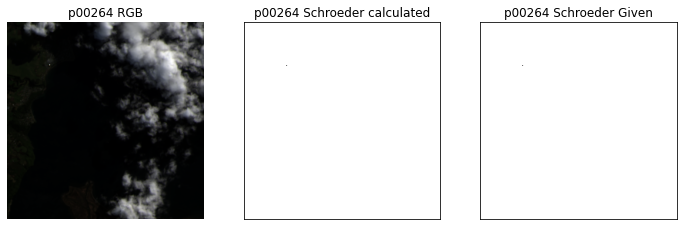

Are masks same ? True


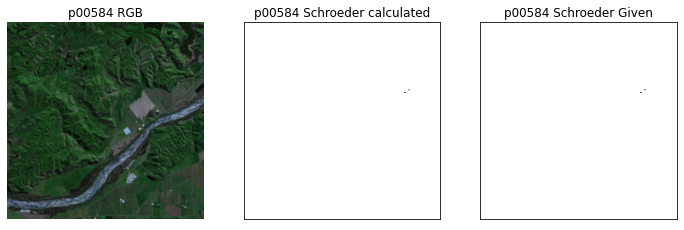

Are masks same ? True


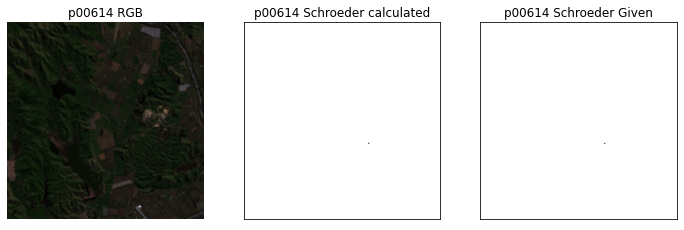

Are masks same ? True


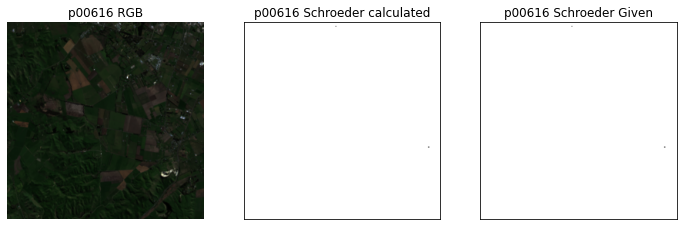

Are masks same ? True


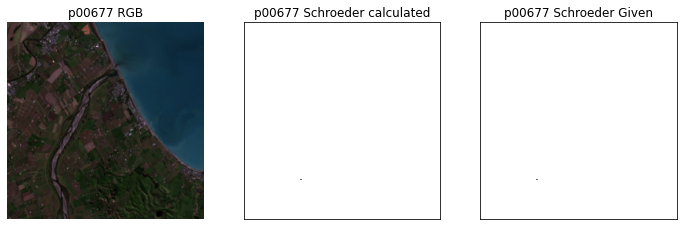

In [70]:
for index,paths in enumerate(zip(scenes_path, masks_path)):
    scene_path, mask_path= paths[0], paths[1]
    img= rasterio.open(scene_path)
    bands= img.read()
    img.close()

    b2= np.zeros((bands.shape[0]+1, bands.shape[1], bands.shape[2]), dtype= np.uint16)
    b2[1:]= bands
    bands= b2

    reflectance = np.zeros(bands.shape, dtype= float)
    corrected = np.zeros(bands.shape, dtype= float)
    
    # Get corrected reflectances for bands 1~7.
    for i in range (1,8):
        reflectance [i], corrected [i] = getReflectance(bands [i], a5, m5, sun_el)

    rgb= np.dstack((corrected[4], corrected[3], corrected[2]))
    rgb= normalise_RGB(rgb)

    schroeder_mask= getFireMaskSchroeder(reflectance)

    img= rasterio.open(mask_path)
    actual_mask= img.read()
    actual_mask= np.squeeze(actual_mask)
    img.close()

    print("Are masks same ?", np.all(actual_mask== schroeder_mask))
    fig, ax = plt.subplots(1, 3, figsize=(12,40))
    scene_index= scene_path.split("/")[-1].split("_")[-1:]
    scene_index= "_".join(scene_index)[:-4]
    ax[0].imshow(rgb)
    ax[0].axis("off")
    ax[0].set_title(scene_index+" RGB")

    ax[1].set_title(scene_index+" Schroeder calculated")
    ax[1].imshow(schroeder_mask, cmap= "binary")
    ax[1].get_xaxis().set_ticks([])
    ax[1].get_yaxis().set_ticks([])

    ax[2].set_title(scene_index+" Schroeder Given")
    ax[2].imshow(actual_mask, cmap= "binary")
    ax[2].get_xaxis().set_ticks([])
    ax[2].get_yaxis().set_ticks([])

    plt.show()

    

# Kumar and Roy masks

In [52]:
#===============================================================================
# EQUATIONS (Kumar-Roy)
#===============================================================================
# The following functions implement the equations in the Kumar-Roy's paper.

def Geq12 (bands):
    '''Eq 12 (unambiguous fires).'''
    return (bands [4] <= 0.53 * bands [7] - 0.214)

#-------------------------------------------------------------------------------

def Geq13 (bands, eq12_mask):
    '''Eq 13 (unambiguous fires near pixels detected by eq 12).'''

    neighborhood = cv2.dilate (eq12_mask.astype (np.uint8), cv2.getStructuringElement (cv2.MORPH_RECT, (3,3))).astype (eq12_mask.dtype)
    # Striclty speaking, we should take out from the neighborhood the pixels
    # that were set in eq12, but as both eq12 and eq13 indicate unambiguous
    # fires, the end result should be the same.
    #neighborhood = np.logical_xor (neighborhood, eq12_mask)
    return (np.logical_and (neighborhood, bands [4] <= 0.35 * bands [6] - 0.044))

#-------------------------------------------------------------------------------

def Geq14 (bands):
    '''Eq 14 (potential fires).'''
    return (bands [4] <= 0.53 * bands [7] - 0.125)

#-------------------------------------------------------------------------------

def Geq15 (bands):
    '''Eq 15 (potential fires).'''
    return (bands [6] <= 1.08 * bands [7] - 0.048)

#-------------------------------------------------------------------------------

def Geq16 (bands):
    '''Eq 16 (water test).'''
    return (np.logical_and (np.logical_and (bands [2] > bands [3], bands [3] > bands [4]), bands [4] > bands [5]))

#-------------------------------------------------------------------------------

def pixelVal(p7,ef,ep,ew):
    # e = (p7>0) & (~ef) & (~ep) & (~ew)
    e = np.logical_and (p7>0, np.logical_and (np.logical_not (ef), np.logical_and (np.logical_not (ep), np.logical_not (ew))))
    return e

#-------------------------------------------------------------------------------

def Geq8and9 (bands, valid, unamb_fires, potential_fires, water):
    '''Eq 8 and 9 (contextual test for potential fires).'''

    # Means and standard deviations are computed ignoring unambiguous and
    # potential fires, as well as water and shadow pixels. The paper is not
    # clear on whether we should consider eq16 for the water pixels, or eq11
    # (from Schroeder, et al.). Eq 16 is used to define the neighborhood size,
    # so we will use it for everything here.
    ignored_pixels = np.logical_or (unamb_fires, np.logical_or (potential_fires, water))
    ignored_pixels = np.logical_or (ignored_pixels, np.logical_not (valid))
    kept_pixels = np.logical_not (ignored_pixels)

    # Reason between bands 7 and 5
    r75 = bands [7] / bands [5]
    r75_ignored = r75.copy ()
    r75_ignored [ignored_pixels] = np.nan # Fire and water pixels are set to NaN.

    band7_ignored = bands [7].copy ()
    band7_ignored [ignored_pixels] = np.nan # Fire and water pixels are set to NaN.

    # Growing region.
    sizes = list(range(5,61+2,2))

    candidates = np.nonzero (potential_fires) # Test potential fires.

    for i in range (len (candidates [0])):
        y = candidates [0][i]
        x = candidates [1][i]
        tested = False
        for w in sizes:
            t = max (0,y-w//2)
            b = min (potential_fires.shape [0], y+w//2+1)
            l = max (0, x-w//2)
            r = min (potential_fires.shape [1], x+w//2+1)

            # Stop when at least 25% of the pixels were kept (not fire or water).
            if np.count_nonzero (kept_pixels [t:b,l:r]) >= 0.25 * (b-t)*(r-l):
                tested = True
                eq8_result = r75 [y,x] > np.nanmean (r75_ignored [t:b,l:r]) + np.maximum (3 * (np.nanstd (r75_ignored [t:b,l:r])), 0.8)
                eq9_result = bands [7][y,x] > np.nanmean (band7_ignored [t:b,l:r]) + np.maximum (3 * (np.nanstd (band7_ignored [t:b,l:r])), 0.08)
                if not (eq8_result) or not (eq9_result):
                    potential_fires [y,x] = False
                break

        if not tested:
            potential_fires [y,x] = False

    return potential_fires


In [53]:
def getFireMaskGOLI (bands):
    '''This is the central function. Receives the (corrected) reflectance bands
and returns a binary fire mask.'''

    # Exclude from every step positions with band 7 <= 0.
    valid = bands [7] > 0
    valid = cv2.erode (valid.astype (np.uint8), cv2.getStructuringElement (cv2.MORPH_RECT, (3,3))).astype (np.uint8)


    # Unambiguous fires (satisfy eq 12 or 13).
    unamb_fires = Geq12 (bands)
    unamb_fires = np.logical_and (valid, unamb_fires)
    if np.any (unamb_fires): # Run eq 13 only if needed.
        unamb_fires = np.logical_or (unamb_fires, Geq13 (bands, unamb_fires))
        unamb_fires = np.logical_and (valid, unamb_fires)

    # Potential fires (satisfy eq 14 or 15).
    potential_fires = Geq14 (bands)
    potential_fires = np.logical_or (potential_fires, Geq15 (bands))
    potential_fires = np.logical_and (valid, potential_fires)

    # Water pixels (used by the contextual test and excluded from the result.
    water = Geq16 (bands)

    # Contextual test for potential fires (eq 8 and 9).
    if np.any (potential_fires):
        potential_fires = Geq8and9 (bands, valid, unamb_fires, potential_fires, water)

    final_mask = np.logical_and (np.logical_or (unamb_fires, potential_fires), np.logical_not (water))
    return (final_mask.astype (int))

In [56]:
lines_to_see= [f"REFLECTANCE_MULT_BAND_{i}" for i in [5,6,7]]
lines_to_see.extend([f"REFLECTANCE_ADD_BAND_{i}" for i in [5,6,7]])
lines_to_see.append("SUN_ELEVATION")

with open("/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Metadata/LC08_L1TP_105068_20200821_20200821_01_RT_MTL.txt") as f:
    for line in f.readlines():
        if any(item in line for item in lines_to_see):
            print(line)

    SUN_ELEVATION = 52.51649057

    REFLECTANCE_MULT_BAND_5 = 2.0000E-05

    REFLECTANCE_MULT_BAND_6 = 2.0000E-05

    REFLECTANCE_MULT_BAND_7 = 2.0000E-05

    REFLECTANCE_ADD_BAND_5 = -0.100000

    REFLECTANCE_ADD_BAND_6 = -0.100000

    REFLECTANCE_ADD_BAND_7 = -0.100000



In [57]:
m5, m6, m7= 2.0000E-05, 2.0000E-05, 2.0000E-05
a5, a6, a7= -0.100000, -0.100000, -0.100000
sun_el = 52.51649057

In [60]:
scenes_path= [os.path.join("/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Scenes", i) for i in 
              os.listdir("/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Scenes") 
              if i.endswith(".tif")]
scenes_path.sort()

masks_path = [os.path.join("/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Masks", i) for i in 
              os.listdir("/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Masks") 
              if (i.endswith(".tif") and "Kumar-Roy" in i)]
masks_path.sort()

In [61]:
display(scenes_path)
display(masks_path)

['/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Scenes/LC08_L1TP_105068_20200821_20200821_01_RT_p00229.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Scenes/LC08_L1TP_105068_20200821_20200821_01_RT_p00259.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Scenes/LC08_L1TP_105068_20200821_20200821_01_RT_p00462.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Scenes/LC08_L1TP_105068_20200821_20200821_01_RT_p00556.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Scenes/LC08_L1TP_105068_20200821_20200821_01_RT_p00722.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Scenes/LC08_L1TP_105068_20200821_20200821_01_RT_p00723.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Scenes/LC08_L1TP_105068_20200821_20200821_01_RT_p00800.tif']

['/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Masks/LC08_L1TP_105068_20200821_20200821_01_RT_Kumar-Roy_p00229.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Masks/LC08_L1TP_105068_20200821_20200821_01_RT_Kumar-Roy_p00259.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Masks/LC08_L1TP_105068_20200821_20200821_01_RT_Kumar-Roy_p00462.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Masks/LC08_L1TP_105068_20200821_20200821_01_RT_Kumar-Roy_p00556.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Masks/LC08_L1TP_105068_20200821_20200821_01_RT_Kumar-Roy_p00722.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Masks/LC08_L1TP_105068_20200821_20200821_01_RT_Kumar-Roy_p00723.tif',
 '/content/Active-Fire-Detection/paper data/Oceania/Images1/z105068/Masks/LC08_L1TP_105068_20200821_20200821_01_RT_Kumar-Roy_p00800.tif']

Are masks same ? True


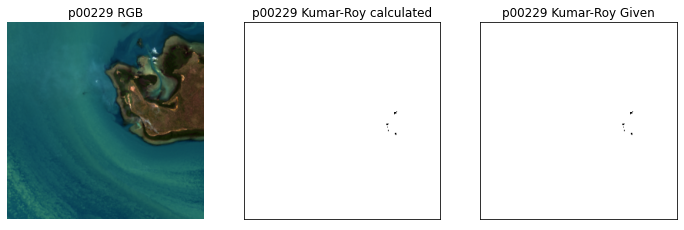

Are masks same ? True


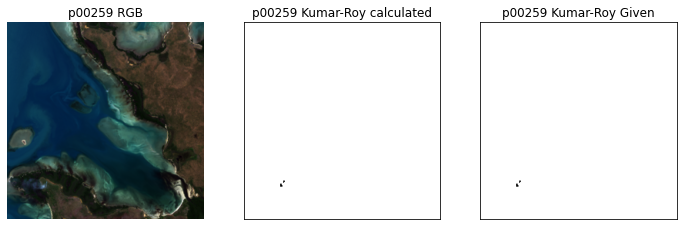

Are masks same ? True


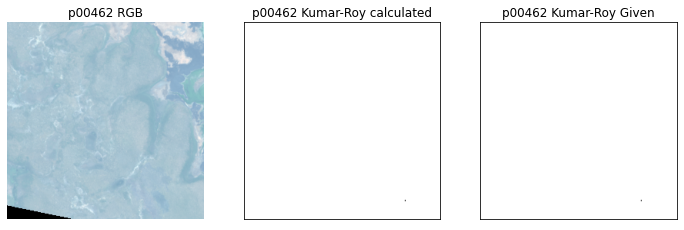

Are masks same ? True


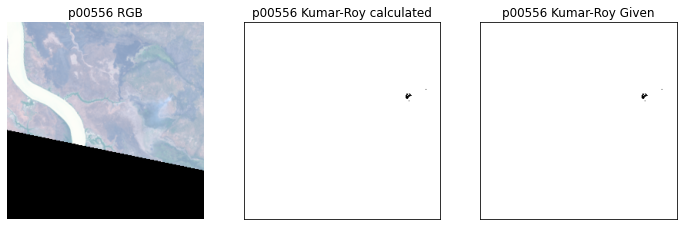

Are masks same ? True


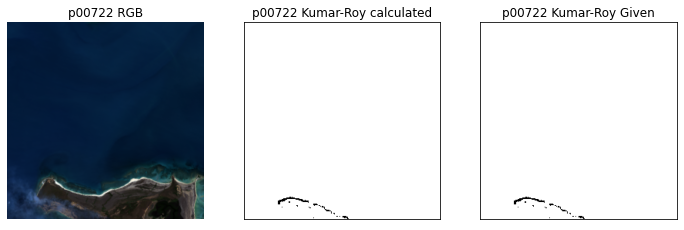

Are masks same ? True


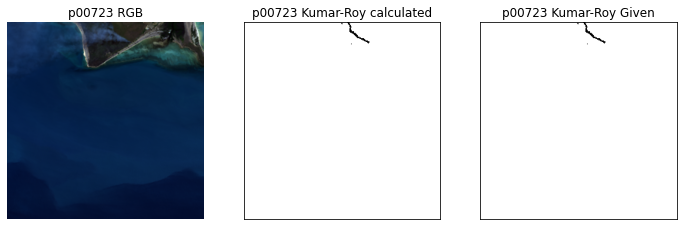

Are masks same ? True


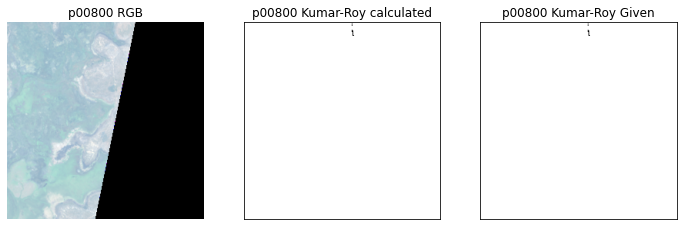

In [65]:
for index,paths in enumerate(zip(scenes_path, masks_path)):
    scene_path, mask_path= paths[0], paths[1]
    img= rasterio.open(scene_path)
    bands= img.read()
    img.close()

    b2= np.zeros((bands.shape[0]+1, bands.shape[1], bands.shape[2]), dtype= np.uint16)
    b2[1:]= bands
    bands= b2

    reflectance = np.zeros(bands.shape, dtype= float)
    corrected = np.zeros(bands.shape, dtype= float)
    
    # Get corrected reflectances for bands 1~7.
    for i in range (1,8):
        reflectance [i], corrected [i] = getReflectance(bands [i], a5, m5, sun_el)

    rgb= np.dstack((corrected[4], corrected[3], corrected[2]))
    rgb= normalise_RGB(rgb)

    kumar_roy_mask= getFireMaskGOLI(corrected)

    img= rasterio.open(mask_path)
    actual_mask= img.read()
    actual_mask= np.squeeze(actual_mask)
    img.close()

    print("Are masks same ?", np.all(actual_mask== kumar_roy_mask))
    fig, ax = plt.subplots(1, 3, figsize=(12,40))
    scene_index= scene_path.split("/")[-1].split("_")[-1:]
    scene_index= "_".join(scene_index)[:-4]
    ax[0].imshow(rgb)
    ax[0].axis("off")
    ax[0].set_title(scene_index+" RGB")

    ax[1].set_title(scene_index+" Kumar-Roy calculated")
    ax[1].imshow(kumar_roy_mask, cmap= "binary")
    ax[1].get_xaxis().set_ticks([])
    ax[1].get_yaxis().set_ticks([])

    ax[2].set_title(scene_index+" Kumar-Roy Given")
    ax[2].imshow(actual_mask, cmap= "binary")
    ax[2].get_xaxis().set_ticks([])
    ax[2].get_yaxis().set_ticks([])

    plt.show()

    